In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# Upload the data
# data will contain everything, names and locations
# df will contain the features used in the modeling
data = pd.read_csv('../data/processed/DecisionTreeData.csv', index_col=0)
data = data.loc[data.Year > 2009]
data.sort_index(inplace=True)
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,Year,NetPrice,Cost,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,Complete,RetentionFT,RetentionPT
47931,00100200,alabama a & m university,Normal,1,3,4,1.0,5.0,0.5129,4930.0,...,2010,8190.0,13762.0,xl,high,high,high,0.3306,0.7457,0.5000
47932,00105200,university of alabama at birmingham,Birmingham,1,3,4,1.0,5.0,0.8243,10661.0,...,2010,12838.0,18003.0,xl,high,highest,highest,0.4108,0.7997,0.7000
47933,02503400,amridge university,Montgomery,1,3,4,2.0,5.0,0.7143,370.0,...,2010,16546.0,20700.0,medium,highest,med,low,0.2308,0.8000,NaN
47934,00105500,university of alabama at huntsville,Huntsville,1,3,4,1.0,5.0,0.6614,5828.0,...,2010,7752.0,17064.0,xl,high,high,highest,0.4364,0.7545,0.5385
47935,00100500,alabama state university,Montgomery,1,3,4,1.0,5.0,0.4372,4882.0,...,2010,4061.0,14390.0,xl,high,high,high,0.2399,0.6352,0.4167


In [3]:
# Separate open and closed schoools
closed = data.loc[data.CURROPER == False]
closed.shape

(2759, 31)

In [4]:
# Resample the minority class
from sklearn.utils import resample
closed_upsample = resample(closed, replace=True, n_samples=7440, random_state=123)

In [5]:
open_df = data.loc[data.CURROPER==True]
open_df.shape

(27923, 31)

In [6]:
current = open_df.loc[data.Year > 2012]
current.shape

(7440, 31)

In [7]:
data = pd.concat([current, closed_upsample], axis = 0)
data.shape

(14880, 31)

In [8]:
data.CURROPER.value_counts()

True     7440
False    7440
Name: CURROPER, dtype: int64

In [9]:
#df contains just the feature to train the model on
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins',\
           'TuitionBins','ExpenditureBins','FacultyBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year']
df = data.drop(to_drop, axis=1)
df.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT
70813,1,3,1.0,4051.0,True,9063.0,7459.0,0.8856,0.1049,0.256983,0.228252,0.150838,19500.0,18888.0,0.2914,0.6314
70814,1,3,1.0,11200.0,True,9033.0,17208.0,0.9106,0.2422,0.445502,0.184674,0.113279,16250.0,19990.0,0.5377,0.8016
70815,1,3,2.0,322.0,True,12057.0,5123.0,0.6721,0.8540,0.288591,0.382550,0.041270,10500.0,12300.0,0.6667,0.3750
70816,1,3,1.0,5525.0,True,8322.0,9352.0,0.6555,0.2640,0.377617,0.149758,0.116747,16500.0,20306.0,0.4835,0.8098
70817,1,3,1.0,5354.0,True,7813.0,7393.0,0.6641,0.1270,0.183563,0.256749,0.109778,15854.5,17400.0,0.2517,0.6219


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14880 entries, 70813 to 50977
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          14880 non-null  int64  
 1   PREDDEG            14880 non-null  int64  
 2   CONTROL            14880 non-null  float64
 3   UGDS               14880 non-null  float64
 4   CURROPER           14880 non-null  bool   
 5   TUITFTE            14880 non-null  float64
 6   INEXPFTE           14880 non-null  float64
 7   PFTFAC             14880 non-null  float64
 8   UG25abv            14880 non-null  float64
 9   COMP_ORIG_YR4_RT   14880 non-null  float64
 10  WDRAW_ORIG_YR4_RT  14880 non-null  float64
 11  ENRL_ORIG_YR4_RT   14880 non-null  float64
 12  DEBT_MDN           14880 non-null  float64
 13  Cost               14880 non-null  float64
 14  Complete           14880 non-null  float64
 15  RetentionFT        14880 non-null  float64
dtypes: bool(1), float6

In [11]:
y = df.CURROPER
X = df.drop('CURROPER', axis=1)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [13]:
X_test.shape

(4464, 15)

# Decision Tree Model
Basis for comparison

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## Explore just the criterion and max_depth features

Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [15]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
    gtree.fit(X_train, y_train)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

In [16]:
gini_max = max(acc_gini)
gini_idx = acc_gini.index(gini_max)
entropy_max = max(acc_entropy)
entropy_idx = acc_entropy.index(entropy_max)

if gini_max > entropy_max:
    depth = max_depth[gini_idx]
    crit = 'gini'
else:
    depth = max_depth[entropy_idx]
    crit='entropy'
    
print(depth)

28


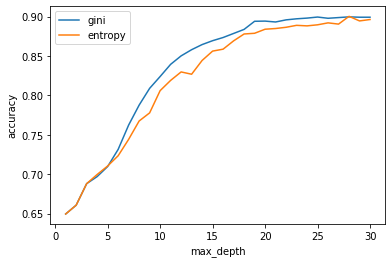

In [17]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [18]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion=crit, max_depth=depth, random_state=21)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=28, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [19]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict_proba(X_test)
#print(type(dt_pred_prob))

In [20]:
# Run this block for model evaluation 
#from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))

Model Metrics
Accuracy: 0.9003136200716846
Balanced accuracy: 0.9003136200716846
Precision score for "Yes" 0.9394982784062961
Recall score for "No" 0.9448924731182796


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, dt_pred))

[[2109  123]
 [ 322 1910]]


In [22]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.87      0.94      0.90      2232
        True       0.94      0.86      0.90      2232

    accuracy                           0.90      4464
   macro avg       0.90      0.90      0.90      4464
weighted avg       0.90      0.90      0.90      4464



In [23]:
importances = modelDT.feature_importances_
#std = np.std([tree.feature_importances_ for tree in modelDT.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature UGDS (0.117419)
2. feature UG25abv (0.102744)
3. feature CONTROL (0.099947)
4. feature NUMBRANCH (0.085429)
5. feature INEXPFTE (0.080201)
6. feature DEBT_MDN (0.079262)
7. feature TUITFTE (0.073930)
8. feature WDRAW_ORIG_YR4_RT (0.066479)
9. feature Cost (0.061912)
10. feature COMP_ORIG_YR4_RT (0.059681)
11. feature Complete (0.050725)
12. feature RetentionFT (0.046895)
13. feature PFTFAC (0.042570)
14. feature ENRL_ORIG_YR4_RT (0.020295)
15. feature PREDDEG (0.012511)


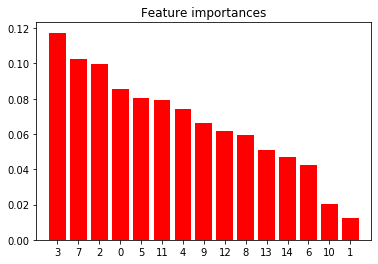

In [24]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center") #yerr=std[indices]
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

CONTROL and UGDS are the most prominent features - that predict open schools. (Control is categorical, so I'm not exactly sure how to interpret it). More enrollment increases prediction of being open.

## Decision Tree Model with various thresholds

In [25]:
threshold = []
accurate=[]
balance_acc = []
pred_proba = []

for thresh in range(50, 100, 5):
    new_pred = []
    for i in range(0, len(dt_pred_prob)):
        # print(len(dt_pred_prob))
        new_pred.append(dt_pred_prob[i, 1] > (thresh / 100.0))
    # print(new_pred)
    accurate.append(metrics.accuracy_score(y_test, new_pred))
    balance_acc.append(metrics.balanced_accuracy_score(y_test, new_pred))
    threshold.append(thresh)
    pred_proba.append(new_pred)

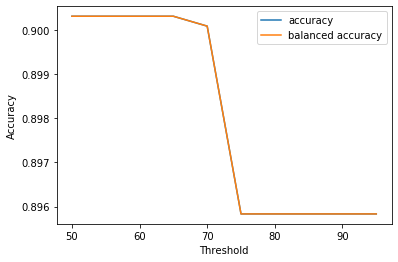

In [26]:
rate = pd.DataFrame({'threshold':pd.Series(threshold),
                     'accuracy':pd.Series(accurate),
                     'balance_acc':pd.Series(balance_acc)})

plt.plot('threshold', 'accuracy', data=rate, label='accuracy')
plt.plot('threshold', 'balance_acc', data=rate, label='balanced accuracy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
print("Balance Accuracy: ", max(balance_acc))
idx = balance_acc.index(max(balance_acc))
print("Threshold: ", threshold[idx])

Balance Accuracy:  0.9003136200716846
Threshold:  50


## AdaBoost model

In [33]:
ABmax_depth = []
score_a = []
score_b = []

for i in range(105, 131, 1):
    atree = AdaBoostClassifier(n_estimators=i, random_state=21)
    atree.fit(X_train, y_train)
    apredict = gtree.predict(X_test)
    score_a.append(metrics.accuracy_score(y_test, apredict))
    ##
    btree = AdaBoostClassifier(modelDT, n_estimators=i, random_state=21)
    btree.fit(X_train, y_train)
    bpredict = btree.predict(X_test)
    score_b.append(metrics.accuracy_score(y_test, bpredict))
    ##
    ABmax_depth.append(i)

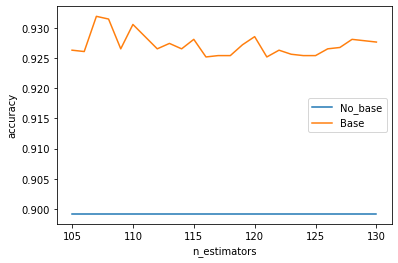

In [34]:
adatrees = pd.DataFrame({'score_a':pd.Series(score_a),
                     'score_b':pd.Series(score_b),
                     'n_estimators':pd.Series(ABmax_depth)})

plt.plot('n_estimators', 'score_a', data=adatrees, label='No_base')
plt.plot('n_estimators', 'score_b', data=adatrees, label='Base')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [35]:
ideal_estimators = max(score_b)
idx = score_b.index(ideal_estimators)
print(ABmax_depth[idx])

107


In [36]:
modelAB = AdaBoostClassifier(modelDT, n_estimators=ABmax_depth[idx], random_state=21)
modelAB.fit(X_train, y_train)
AB_pred = modelAB.predict(X_test)
print(metrics.accuracy_score(y_test, AB_pred))

0.931899641577061


In [37]:
print(confusion_matrix(y_test, AB_pred))

[[2125  107]
 [ 197 2035]]


In [38]:
print(classification_report(y_test, AB_pred))

              precision    recall  f1-score   support

       False       0.92      0.95      0.93      2232
        True       0.95      0.91      0.93      2232

    accuracy                           0.93      4464
   macro avg       0.93      0.93      0.93      4464
weighted avg       0.93      0.93      0.93      4464



In [39]:
importances = modelAB.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelAB.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature RetentionFT (nan)
2. feature Complete (nan)
3. feature Cost (nan)
4. feature DEBT_MDN (nan)
5. feature ENRL_ORIG_YR4_RT (nan)
6. feature WDRAW_ORIG_YR4_RT (nan)
7. feature COMP_ORIG_YR4_RT (nan)
8. feature UG25abv (nan)
9. feature PFTFAC (nan)
10. feature INEXPFTE (nan)
11. feature TUITFTE (nan)
12. feature UGDS (nan)
13. feature PREDDEG (nan)
14. feature NUMBRANCH (nan)
15. feature CONTROL (-0.174916)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:578: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


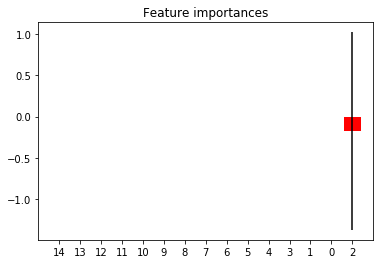

In [40]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Explore different threshold values for AB Model

In [41]:
AB_pred_prob = modelAB.predict_proba(X_test)

ABthreshold = []
ABaccurate=[]
ABbalance_acc = []
ABpred_proba = []

for thresh in range(50, 100, 5):
    new_pred = []
    for i in range(0, len(AB_pred_prob)):
        # print(len(dt_pred_prob))
        new_pred.append(AB_pred_prob[i, 1] > (thresh / 100.0))
    # print(new_pred)
    ABaccurate.append(metrics.accuracy_score(y_test, new_pred))
    ABbalance_acc.append(metrics.balanced_accuracy_score(y_test, new_pred))
    ABthreshold.append(thresh)
    ABpred_proba.append(new_pred)

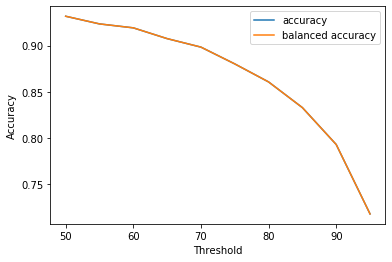

In [42]:
ABrate = pd.DataFrame({'threshold':pd.Series(ABthreshold),
                     'accuracy':pd.Series(ABaccurate),
                     'balance_acc':pd.Series(ABbalance_acc)})

plt.plot('threshold', 'accuracy', data=ABrate, label='accuracy')
plt.plot('threshold', 'balance_acc', data=ABrate, label='balanced accuracy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Exploration of misclassified schools

We are interested in predicting schools that might be in danger of closing. This would be schools that are currently open, but that the model predicts are closed. (These would be the "false negative" cases.) There are 224 schools in this class that could be explored further.

In [47]:
result_dict = {'CURROPER':y_test, 'Predicted':pred65}
results = pd.DataFrame(result_dict)
results.head()

,CURROPER,Predicted
74577,True,True
73237,True,True
72626,True,True
69021,False,False
60906,False,False


In [48]:
predicted = pd.concat([X_test, results], axis=1)
predicted.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
74577,1,1,1.0,1938.0,2961.0,4723.0,0.4727,0.3252,0.089376,0.236088,0.048904,8040.0,8118.0,0.1788,0.4679,True,True
73237,1,3,2.0,650.0,6524.0,1770.0,0.7241,0.0046,0.000000,0.000000,0.057895,14500.0,23043.0,0.0991,0.6795,True,True
72626,9,1,3.0,145.0,9248.0,3132.0,0.7222,0.5724,0.626406,0.177620,0.000000,9163.0,28379.0,0.5128,0.5357,True,True
69021,1,1,3.0,29.0,6573.0,1058.0,1.0000,0.5714,0.000000,0.000000,0.000000,1167.0,9862.0,0.7500,0.8462,False,False
60906,1,1,3.0,128.0,19550.0,1344.0,0.7222,0.5469,0.598592,0.218310,0.000000,7494.0,21666.0,0.7759,0.3962,False,False


In [49]:
false_pos = predicted.loc[(predicted.Predicted == True) & (predicted.CURROPER == False)]
false_pos.shape

(107, 17)

In [50]:
false_neg = predicted.loc[(predicted.Predicted==False) & (predicted.CURROPER==True)]
false_neg.shape

(198, 17)

## Generate graphs for the report

In [51]:
predicted['Result'] = np.nan
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==True), 'Result'] = 'TP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==False), 'Result'] = 'TN'
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==False), 'Result'] = 'FP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==True), 'Result'] = 'FN'
print(predicted.Result)

74577    TP
73237    TP
72626    TP
69021    TN
60906    TN
         ..
53253    TN
53557    TN
78133    TP
72122    TP
73430    TN
Name: Result, Length: 4464, dtype: object


In [52]:
to_graph = pd.merge(predicted, data)
to_graph.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
0,1,1,1.0,1938.0,2961.0,4723.0,0.4727,0.3252,0.089376,0.236088,...,NaN,4949.0,0.2334,2013,3478.0,large,med,med,med,0.4355
1,1,3,2.0,650.0,6524.0,1770.0,0.7241,0.0046,0.000000,0.000000,...,1.0,2365.0,0.0000,2013,16809.0,large,high,low,low,NaN
2,9,1,3.0,145.0,9248.0,3132.0,0.7222,0.5724,0.626406,0.177620,...,NaN,NaN,0.5318,2013,24606.0,small,high,med,NaN,NaN
3,1,1,3.0,29.0,6573.0,1058.0,1.0000,0.5714,0.000000,0.000000,...,NaN,NaN,0.5946,2012,4034.0,small,high,low,NaN,NaN
4,1,1,3.0,29.0,6573.0,1058.0,1.0000,0.5714,0.000000,0.000000,...,NaN,NaN,0.5946,2012,4034.0,small,high,low,NaN,NaN


In [53]:
to_graph.CONTROL = to_graph.CONTROL.astype('str')
to_graph.CONTROL.loc[to_graph.CONTROL == '1.0'] = 'Public'
to_graph.CONTROL.loc[to_graph.CONTROL == '2.0'] = 'NonProfit'
to_graph.CONTROL.loc[to_graph.CONTROL == '3.0'] = 'ForProfit'

to_graph.PREDDEG = to_graph.PREDDEG.astype('str')
#to_graph.drop(['EnrollmentBins', 'TuitionBins', 'ExpenditureBins', 'FacultyBins'], axis=1, inplace=True)
to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11153 entries, 0 to 11152
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          11153 non-null  int64  
 1   PREDDEG            11153 non-null  object 
 2   CONTROL            11153 non-null  object 
 3   UGDS               11153 non-null  float64
 4   TUITFTE            11153 non-null  float64
 5   INEXPFTE           11153 non-null  float64
 6   PFTFAC             11153 non-null  float64
 7   UG25abv            11153 non-null  float64
 8   COMP_ORIG_YR4_RT   11153 non-null  float64
 9   WDRAW_ORIG_YR4_RT  11153 non-null  float64
 10  ENRL_ORIG_YR4_RT   11153 non-null  float64
 11  DEBT_MDN           11153 non-null  float64
 12  Cost               11153 non-null  float64
 13  Complete           11153 non-null  float64
 14  RetentionFT        11153 non-null  float64
 15  CURROPER           11153 non-null  bool   
 16  Predicted          111

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [54]:
predControl = to_graph.pivot_table(index='PREDDEG', columns=['CONTROL','Result'], aggfunc='size')
print(predControl)

CONTROL ForProfit                      NonProfit                     Public  \
Result         FN    FP      TN     TP        FN    FP     TN     TP     FN   
PREDDEG                                                                       
0            32.0  11.0   822.0  396.0       4.0   1.0  123.0   76.0    1.0   
1           119.0  80.0  4425.0  588.0       5.0  13.0  473.0   53.0    7.0   
2            19.0   9.0   741.0  153.0       5.0  12.0   70.0   43.0    2.0   
3             4.0  18.0   463.0   68.0       5.0  17.0  273.0  358.0    1.0   
4             1.0   NaN   150.0   11.0       3.0   NaN  155.0   51.0    NaN   

CONTROL                      
Result     FP     TN     TP  
PREDDEG                      
0         5.0  111.0   27.0  
1        15.0  424.0  157.0  
2         1.0  106.0  222.0  
3         NaN   28.0  186.0  
4         NaN    7.0    3.0  


In [55]:
false_neg = to_graph.loc[to_graph.Result == 'FN']
false_neg.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
346,1,1,ForProfit,37.0,1665.0,5980.0,1.0000,0.7027,0.400000,0.220000,...,NaN,NaN,1.0000,2013,10167.0,small,low,med,NaN,NaN
707,1,1,ForProfit,5.0,5042.0,7060.0,1.0000,0.2000,0.567568,0.000000,...,NaN,NaN,0.4138,2013,8328.0,small,med,high,NaN,NaN
795,1,1,ForProfit,85.0,3202.0,3424.0,0.2500,0.8353,0.458333,0.207547,...,NaN,NaN,0.6634,2013,13543.0,small,med,med,NaN,0.7826
995,1,2,ForProfit,557.0,9465.0,3661.0,0.3235,0.5673,0.414948,0.314433,...,NaN,4376.0,0.6365,2013,18273.0,large,high,med,med,NaN
1097,1,1,ForProfit,943.0,6281.0,2558.0,0.7143,0.8282,0.692847,0.147265,...,NaN,NaN,0.7432,2013,19813.0,large,high,med,NaN,0.9231


## UGDS - Undergraduate enrollment

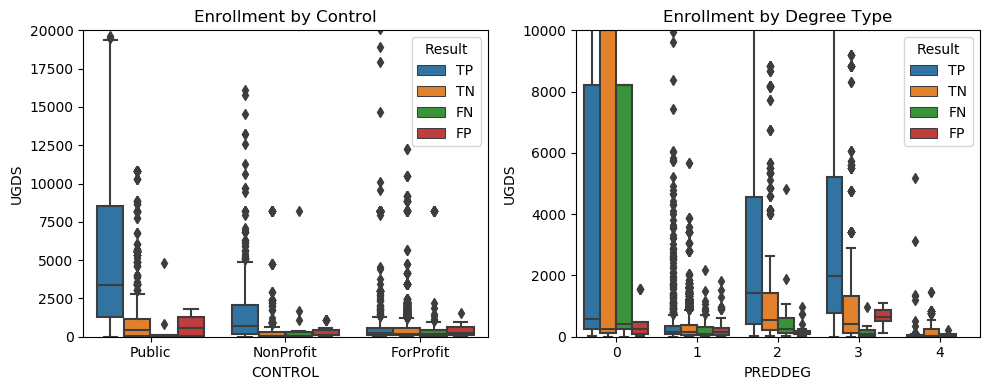

In [56]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 20000)
plt.title('Enrollment by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 10000)
plt.title('Enrollment by Degree Type')
plt.tight_layout()

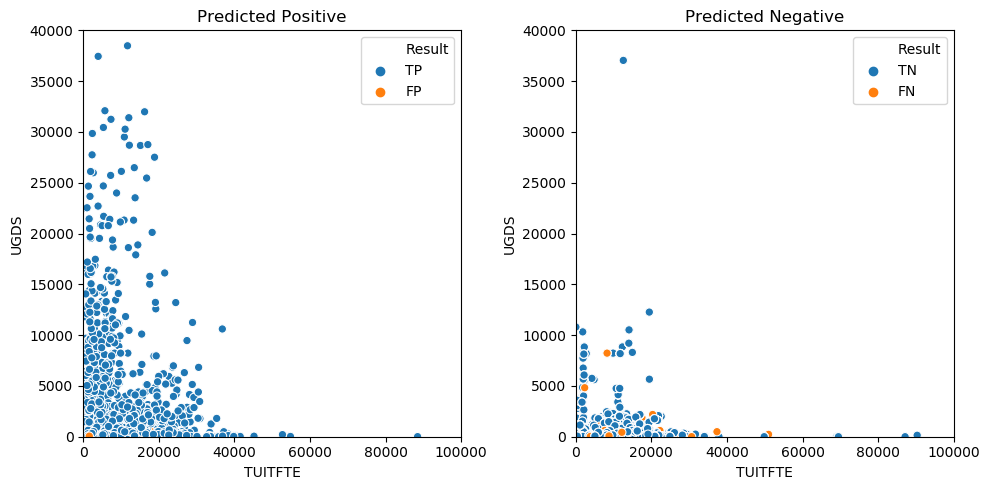

In [57]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
plt.title('Predicted Positive')
plt.xlim(0,100000)
plt.ylim(0,40000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
plt.title('Predicted Negative')
plt.xlim(0,100000)
plt.ylim(0,40000)
plt.tight_layout()
plt.show()

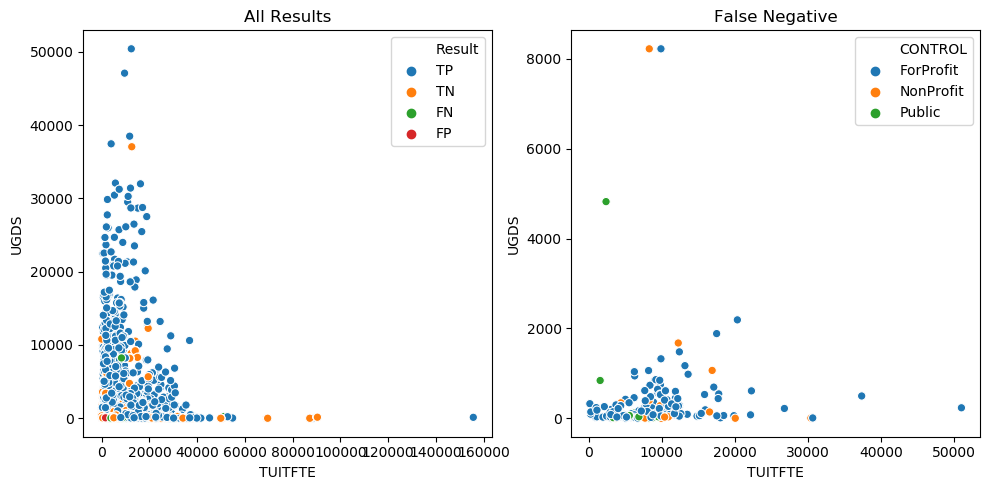

In [58]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All Results')
#plt.xlim(0,100000)
#plt.ylim(0,40000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
#plt.xlim(0,100000)
#plt.ylim(0,40000)
#plt.xlim(0,40000)
#plt.ylim(0,10000)
plt.tight_layout()
plt.show()

## Tuition and Cost

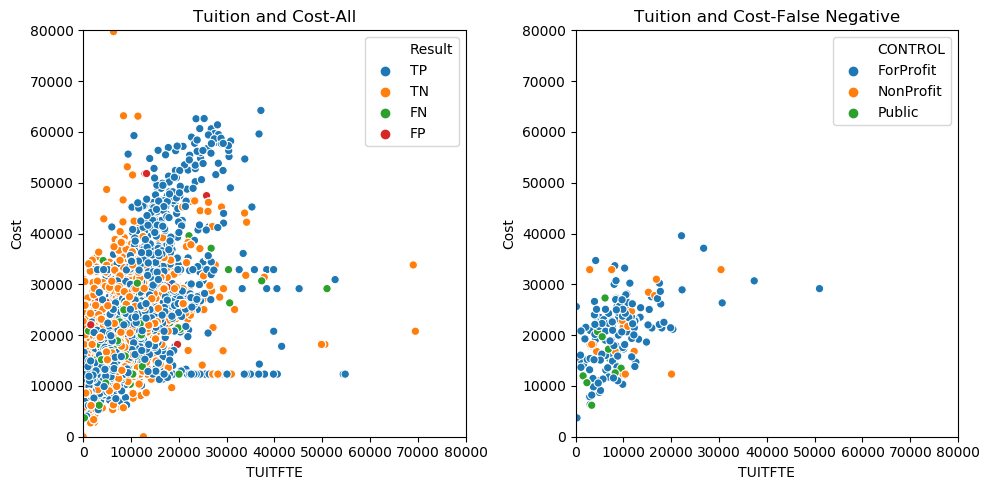

In [59]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph, hue = 'Result')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-All')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-False Negative')
plt.tight_layout()
plt.show()

## Cost and Debt

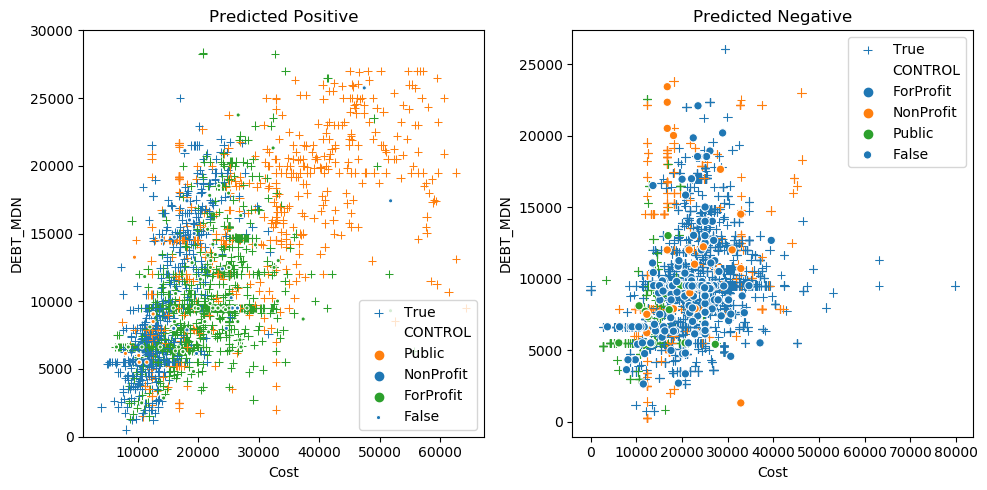

In [60]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='CONTROL')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Positive')
plt.ylim(0,30000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()

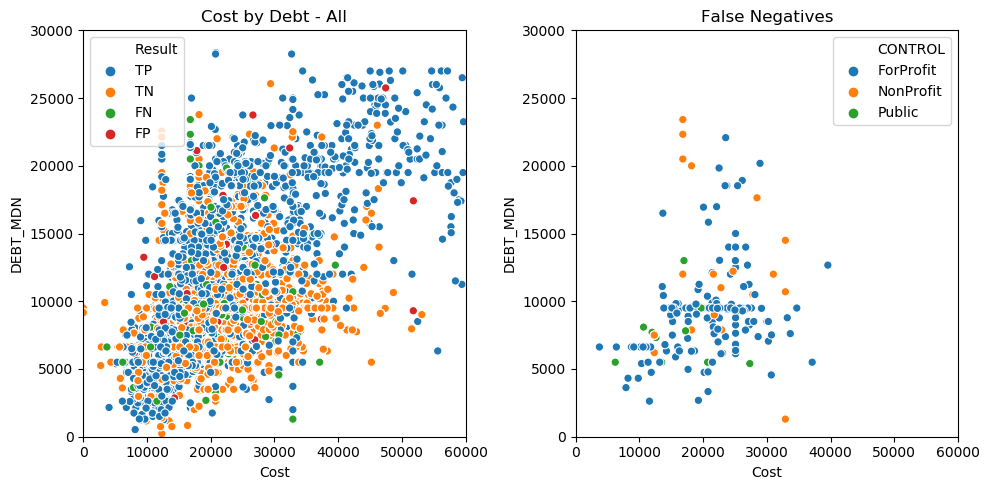

In [61]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph, hue='Result')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.title('Cost by Debt - All')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.title('False Negatives')
plt.ylim(0,30000)
plt.xlim(0,60000)
plt.tight_layout()
plt.show()

## NumBranch

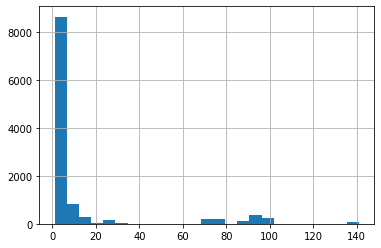

In [62]:
to_graph.NUMBRANCH.hist(bins=25)

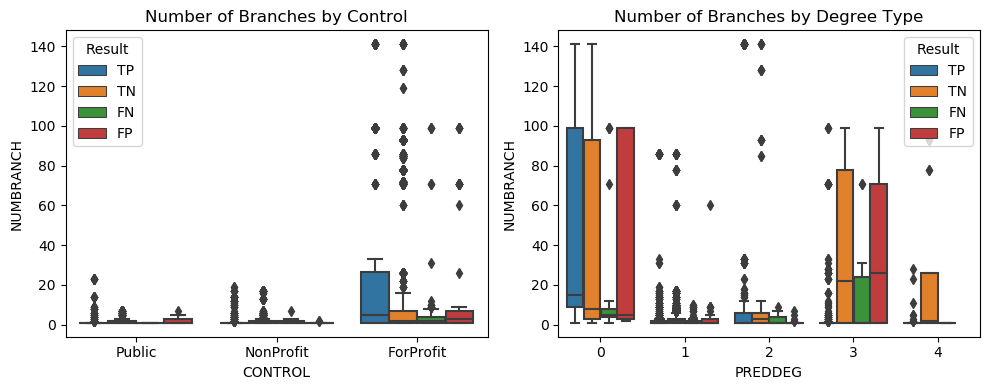

In [63]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Degree Type')
plt.tight_layout()
plt.show()

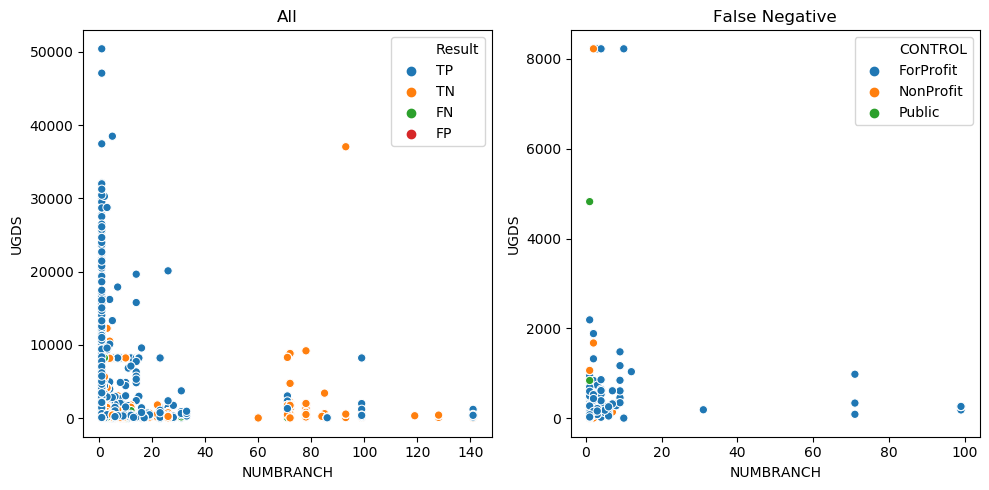

In [64]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All')

plt.subplot(1, 2, 2)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
plt.tight_layout()
plt.show()

## Instructional Expenditure

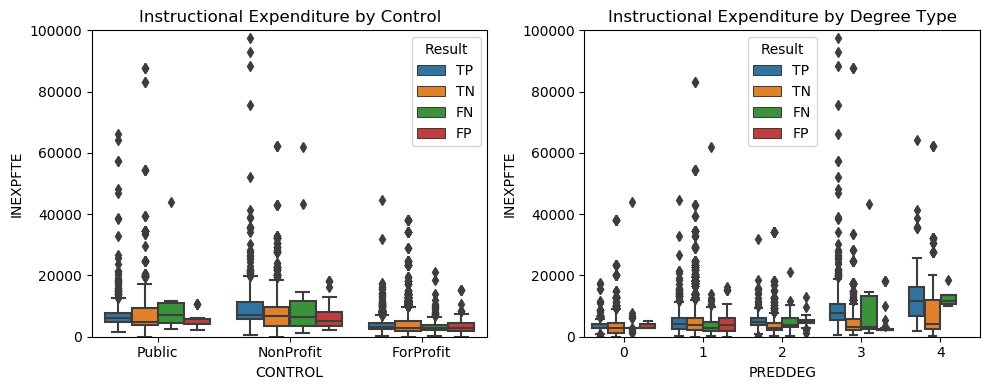

In [65]:
fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Control')

plt.subplot(1, 2, 2)
sns.boxplot('PREDDEG', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Instructional Expenditure by Degree Type')
plt.tight_layout()
plt.show()

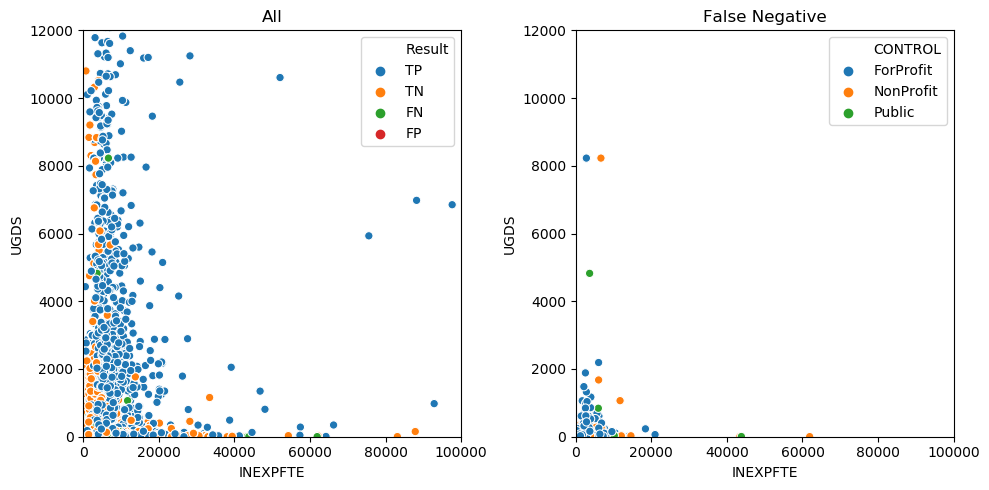

In [66]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph, hue = 'Result')
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('All')

plt.subplot(1, 2, 2)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.xlim(0, 100000)
plt.ylim(0, 12000)
plt.title('False Negative')
plt.tight_layout()
plt.show()

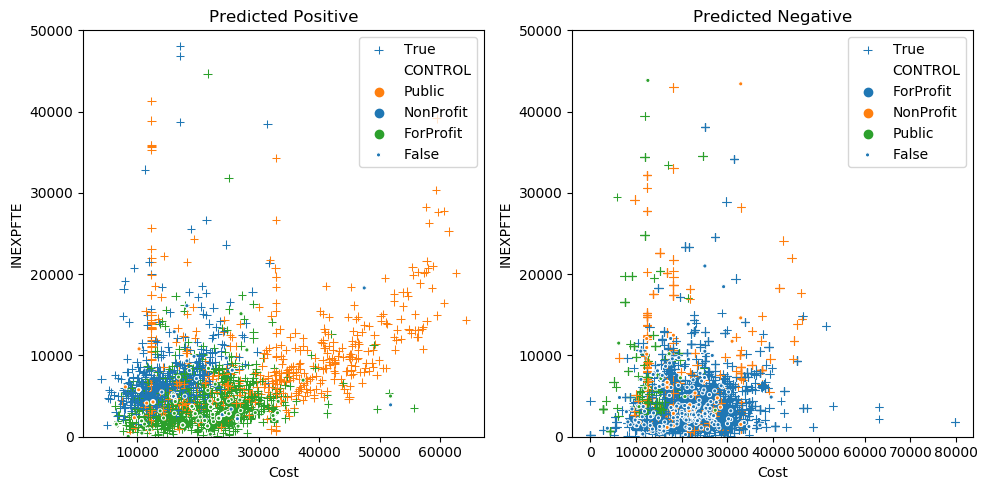

In [67]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylim(0, 50000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylim(0, 50000)
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()